In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18
np.random.seed(123)

In [6]:
%ls ./data/

ch6_1_1_.csv  ch6_2_10.csv  ch6_p2.csv    ch7_1_2_.csv
ch6_1_2.csv   ch6_2_2.csv   ch6_p3.csv    readme.txt*
ch6_1_3.csv   ch6_300.csv   ch6_p5.csv    scr_09/
ch6_2_1.csv   ch6_p1.csv    ch7_1_1_.csv  scr_12/


In [9]:
df = pd.read_csv('./data/ch6_1_1.csv', header=None)
df.columns = ['cost']

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


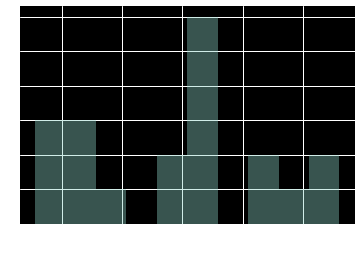

In [10]:
sns.distplot(df['cost'], kde=False, bins=10)

In [11]:
stan_model = """
    data{
        int N;
        real X[N];
    }
    
    parameters{
        real mu;
        real<lower=0> sigma;
    }
    
    model{
        for(n in 1:N){
            X[n] ~ normal(mu, sigma);
        }
    }
    
    generated quantities{
        real<lower=0, upper=1> mu_over1;
        real<lower=0, upper=1> mu_over2;
        real es;
        real<lower=0, upper=1> es_over;
        
        mu_over1 <- step(mu - 2500);
        mu_over2 <- step(mu - 3000);
        es <- (mu - 2500)/sigma;
        es_over <- step(es - 0.8);
    }
"""

In [12]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f5f1df3130befd603a36a740fbeaaa1 NOW.


In [13]:
stan_data = {"N": df.shape[0], "X": df['cost']}

In [14]:
fit = sm.sampling(data=stan_data, iter=11000, warmup=1000, chains=3, seed=1234)

In [15]:
fit

Inference for Stan model: anon_model_4f5f1df3130befd603a36a740fbeaaa1.
3 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=30000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       2927.0    1.32 186.46 2558.1 2806.3 2927.6 3047.3 3296.2  19839    1.0
sigma    814.13    1.06 144.78 588.36 712.15 794.09 894.89 1149.9  18668    1.0
mu_over1   0.99  8.4e-4   0.11    1.0    1.0    1.0    1.0    1.0  17114    1.0
mu_over2   0.34  3.1e-3   0.47    0.0    0.0    0.0    1.0    1.0  23570    1.0
es         0.54  1.6e-3   0.24   0.07   0.38   0.54   0.71   1.01  22262    1.0
es_over    0.14  2.4e-3   0.35    0.0    0.0    0.0    0.0    1.0  22286    1.0
lp__     -136.5  9.9e-3   1.05 -139.3 -136.9 -136.1 -135.7 -135.4  11427    1.0

Samples were drawn using NUTS at Thu Sep 13 23:23:33 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduc

In [16]:
arr = fit.get_posterior_mean()
arr

array([[ 2.92292671e+03,  2.93109915e+03,  2.92720888e+03],
       [ 8.13617912e+02,  8.14512578e+02,  8.14254381e+02],
       [ 9.86200000e-01,  9.87700000e-01,  9.89300000e-01],
       [ 3.33200000e-01,  3.50200000e-01,  3.40300000e-01],
       [ 5.35036942e-01,  5.45209523e-01,  5.39692429e-01],
       [ 1.38600000e-01,  1.48800000e-01,  1.44500000e-01],
       [-1.36500198e+02, -1.36543031e+02, -1.36502360e+02]])

In [17]:
la = fit.extract(permuted=True) # サンプル列
names = fit.model_pars #パラメーター名

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


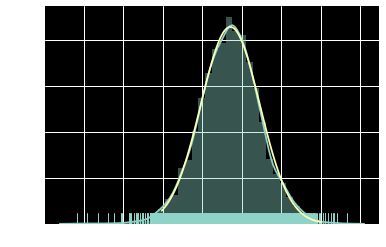

In [18]:
from scipy.stats import norm, gamma
u = la['mu'].mean()
s = la['mu'].std()
sns.distplot(la['mu'][:5000], kde=True,rug=True, norm_hist=False, bins=40)
x = np.linspace(norm.ppf(0.01, loc=u, scale=s), norm.ppf(0.999, loc=u, scale=s), 100)
plt.plot(x, norm.pdf(x=x, loc=u, scale=s))

In [19]:
# https://jb102.blogspot.com/2017/10/22-histogram.html
weights = np.ones(len(a))/float(len(a))
plt.hist( a, weights=weights )

NameError: name 'a' is not defined

In [24]:
uu = df['cost'].mean()
ss = df['cost'].std()

In [30]:
print('ベイズ平均:  {},  通常平均:  {}'.format(u, uu))
print('ベイズ偏差:  {},  通常偏差:  {}'.format(la['sigma'].mean(), ss))

ベイズ平均:  2927.0782477230937,  通常平均:  2926.5
ベイズ偏差:  814.1282899971615,  通常偏差:  756.8721994602454


/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


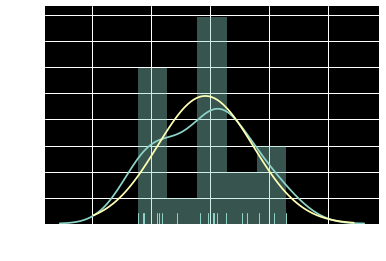

In [32]:
mu = la['mu'].mean()
sig = la['sigma'].mean()
sns.distplot(df['cost'], kde=True,rug=True, norm_hist=False, bins=5)
x = np.linspace(norm.ppf(0.01, loc=mu, scale=sig), norm.ppf(0.999, loc=mu, scale=sig), 100)
plt.plot(x, norm.pdf(x=x, loc=mu, scale=sig))